#### Imports & Downloads

In [120]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import cross_val_score
import Vectorizer

### Einladen der Daten

#### Originaldaten ohne umfassende Vorverarbeitung

In [4]:
current_dir = os.getcwd()
csv_path_train = os.path.abspath(os.path.join(current_dir, '../../../data/twitter_hate-speech/train_basic_cleaned.csv'))
df = pd.read_csv(csv_path_train, encoding='utf-8', index_col=0)

df.head()

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation


In [5]:
df['label'].value_counts()
positive = len(df[df['label'] == 1])
negative = len(df[df['label'] == 0])
print("Positive:", positive)
print("Negative:", negative)
print("Verhältnis:", negative / positive)

Positive: 2013
Negative: 27517
Verhältnis: 13.669647292598112


#### Vorverarbeitete Daten

In [6]:
current_dir = os.getcwd()
csv_path_train = os.path.abspath(os.path.join(current_dir, '../../../data/twitter_hate-speech/train_cleaned.csv'))
df_cleaned = pd.read_csv(csv_path_train, encoding='utf-8', index_col=0)

df_cleaned.head()

,label,tweet,tweet_cleaned,user_handle,hashtags,emojis
id,,,,,,
1,0,@user when a father is dysfunctional and is s...,father selfish drag kid run,1,['#run'],NaN
2,0,@user @user thanks for #lyft credit i can't us...,thank lyft credit use cause offer van,2,"['#lyft', '#disapointed', '#getthanked']",NaN
3,0,bihday your majesty,bihday majesty,0,[],NaN
4,0,#model i love u take with u all the time in ...,model take time mobile phone kiss sunglass mou...,0,['#model'],":mobile_phone:,:kissing_face_with_smiling_eyes..."
5,0,factsguide: society now #motivation,factsguide society motivation,0,['#motivation'],NaN


In [7]:
df_cleaned.dropna(subset=['tweet_cleaned'], inplace=True)  #irgendwoher kommt eine na row in tweet_cleaned, dadurch funktioniert der Vectorizer nicht

In [8]:
df_cleaned['label'].value_counts()
positive = len(df_cleaned[df_cleaned['label'] == 1])
negative = len(df_cleaned[df_cleaned['label'] == 0])
print("Positive:", positive)
print("Negative:", negative)
print("Verhältnis:", negative / positive)

Positive: 1811
Negative: 25838
Verhältnis: 14.267255659856433


Verhältnis hat sich durch die Bereinigung sogar noch weiter verschlechter

### Train/Test Split

In [9]:
def print_pos_neg(y_train, y_test):
    positive = np.count_nonzero(y_train == 1)
    negative = np.count_nonzero(y_train == 0)
    print("Train")
    print("- Positive:", positive)
    print("- Negative:", negative)
    print("- Verhältnis:", negative / positive)

    positive = np.count_nonzero(y_test == 1)
    negative = np.count_nonzero(y_test == 0)
    print("Test")
    print("- Positive:", positive)
    print("- Negative:", negative)
    print("- Verhältnis:", negative / positive)

In [10]:
X_base = df["tweet"]
y_base = df["label"]

In [11]:
# mit stratify
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y_base, test_size=0.3, stratify=y_base,
                                                                        random_state=42)
print_pos_neg(y_train_base, y_test_base)

Train
- Positive: 1409
- Negative: 19262
- Verhältnis: 13.67068843151171
Test
- Positive: 604
- Negative: 8255
- Verhältnis: 13.667218543046358


In [12]:
X_clean = df_cleaned["tweet_cleaned"]
y_clean = df_cleaned["label"]

In [13]:
# mit stratify
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(X_clean, y_clean, test_size=0.3,
                                                                            stratify=y_clean, random_state=42)
print_pos_neg(y_train_clean, y_test_clean)

Train
- Positive: 1268
- Negative: 18086
- Verhältnis: 14.263406940063092
Test
- Positive: 543
- Negative: 7752
- Verhältnis: 14.276243093922652


### Vektorisierung

In [15]:
X_train_base, X_test_base = Vectorizer.get_tfidf_vectorized(X_train_base, X_test_base)

In [16]:
print("X_train_base shape", X_train_base.shape)
print("y_train_base shape", y_train_base.shape)

print("X_test_base shape", X_test_base.shape)
print("y_test_base shape", y_test_base.shape)

X_train_base shape (20671, 5000)
y_train_base shape (20671,)
X_test_base shape (8859, 5000)
y_test_base shape (8859,)


In [17]:
X_train_clean, X_test_clean = Vectorizer.get_tfidf_vectorized(X_train_clean, X_test_clean)

In [18]:
print("X_train_clean shape", X_train_clean.shape)
print("y_train_clean shape", y_train_clean.shape)

print("X_test_clean shape", X_test_clean.shape)
print("y_test_clean shape", y_test_clean.shape)

X_train_clean shape (19354, 5000)
y_train_clean shape (19354,)
X_test_clean shape (8295, 5000)
y_test_clean shape (8295,)


### 2. Ensemble Models

In [30]:
evaluation = pd.DataFrame(
    columns=["model", "variant", "train_acc", "train_prec", "train_rec", "train_f1", "test_acc", "test_prec",
             "test_rec", "test_f1"])

In [31]:
def add_to_eval_df(model, model_name, variant, x_data_train, y_data_train, x_data_test, y_data_test):
    train_acc = model.score(x_data_train, y_data_train)
    train_precision = precision_score(y_data_train, model.predict(x_data_train))
    train_recall = recall_score(y_data_train, model.predict(x_data_train))
    train_f1 = f1_score(y_data_train, model.predict(x_data_train))

    test_acc = model.score(x_data_test, y_data_test)
    test_precision = precision_score(y_data_test, model.predict(x_data_test))
    test_recall = recall_score(y_data_test, model.predict(x_data_test))
    test_f1 = f1_score(y_data_test, model.predict(x_data_test))

    evaluation.loc[len(evaluation.index)] = [model_name, variant, train_acc, train_precision, train_recall, train_f1,
                                             test_acc, test_precision, test_recall, test_f1]

In [121]:
def evaluate_model(model, x_test, y_test, sampling_method):
    pred = model.predict(x_test)
    accscore = metrics.accuracy_score(pred, y_test)

    print(f'{sampling_method} model accuracy for classification is =', str('{:04.2f}'.format(accscore * 100)) + '%')
    print('------------------------------------------------')
    print('Confusion Matrix:')
    print(pd.DataFrame(confusion_matrix(y_test, pred)))
    print('------------------------------------------------')
    print('Classification Report:')
    print(classification_report(y_test, pred))

    probs = model.predict_proba(x_test)
    preds = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


#### 2.1 Bagging

##### 2.1.1a RandomForest untuned

In [33]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train_clean, y_train_clean)

RandomForestClassifier(n_jobs=-1)

In [34]:
evaluate_model(rf, X_test_clean, y_test_clean, "none")
add_to_eval_df(rf, "RandomForestClassifier", "clean", X_train_clean, y_train_clean, X_test_clean, y_test_clean)

none model accuracy for classification is = 95.62%
------------------------------------------------
Confusion Matrix:
      0    1
0  7697   55
1   308  235
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7752
           1       0.81      0.43      0.56       543

    accuracy                           0.96      8295
   macro avg       0.89      0.71      0.77      8295
weighted avg       0.95      0.96      0.95      8295



In [111]:
cv = cross_val_score(rf, X_train_clean, y_train_clean, cv=10, scoring='f1', verbose=10)

[CV] START .....................................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.492) total time=  12.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.3s remaining:    0.0s


[CV] END ................................ score: (test=0.521) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   14.8s remaining:    0.0s


[CV] END ................................ score: (test=0.523) total time=   2.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.6s remaining:    0.0s


[CV] END ................................ score: (test=0.505) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   20.1s remaining:    0.0s


[CV] END ................................ score: (test=0.481) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.5s remaining:    0.0s


[CV] END ................................ score: (test=0.583) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   24.9s remaining:    0.0s


[CV] END ................................ score: (test=0.503) total time=   2.4s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   27.3s remaining:    0.0s


[CV] END ................................ score: (test=0.542) total time=   2.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   29.7s remaining:    0.0s


[CV] END ................................ score: (test=0.515) total time=   2.5s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   32.3s remaining:    0.0s


[CV] END ................................ score: (test=0.585) total time=   2.5s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   34.9s finished


In [112]:
np.mean(cv)

0.5250411735177817

##### 2.1.1b RandomForest tuned

In [74]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [9, 11, 13],
}

In [75]:
random_search = RandomizedSearchCV(RandomForestClassifier(n_jobs=-1),
                                   param_grid,
                                   scoring='f1',
                                   verbose=10)
random_search.fit(X_train_clean, y_train_clean)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START max_depth=3, max_features=log2, max_leaf_nodes=9, n_estimators=250
[CV 1/5; 1/10] END max_depth=3, max_features=log2, max_leaf_nodes=9, n_estimators=250;, score=0.000 total time=   1.2s
[CV 2/5; 1/10] START max_depth=3, max_features=log2, max_leaf_nodes=9, n_estimators=250
[CV 2/5; 1/10] END max_depth=3, max_features=log2, max_leaf_nodes=9, n_estimators=250;, score=0.000 total time=   0.7s
[CV 3/5; 1/10] START max_depth=3, max_features=log2, max_leaf_nodes=9, n_estimators=250
[CV 3/5; 1/10] END max_depth=3, max_features=log2, max_leaf_nodes=9, n_estimators=250;, score=0.000 total time=   1.8s
[CV 4/5; 1/10] START max_depth=3, max_features=log2, max_leaf_nodes=9, n_estimators=250
[CV 4/5; 1/10] END max_depth=3, max_features=log2, max_leaf_nodes=9, n_estimators=250;, score=0.000 total time=   1.7s
[CV 5/5; 1/10] START max_depth=3, max_features=log2, max_leaf_nodes=9, n_estimators=250
[CV 5/5; 1/10] END max_

RandomizedSearchCV(estimator=RandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [3, 6, 9],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [9, 11, 13],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring='f1', verbose=10)

In [76]:
print(random_search.best_estimator_)

RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=11,
                       n_estimators=200, n_jobs=-1)


In [77]:
rf_tuned = RandomForestClassifier(**random_search.best_params_)
rf_tuned.fit(X_train_clean, y_train_clean)

RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=11,
                       n_estimators=200)

In [99]:
evaluate_model(rf_tuned, X_test_clean, y_test_clean, "none")
add_to_eval_df(rf_tuned, "RandomForestClassifier-tuned", "clean", X_train_clean, y_train_clean, X_test_clean, y_test_clean)

none model accuracy for classification is = 94.36%
------------------------------------------------
Confusion Matrix:
      0    1
0  7712   40
1   428  115
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7752
           1       0.74      0.21      0.33       543

    accuracy                           0.94      8295
   macro avg       0.84      0.60      0.65      8295
weighted avg       0.93      0.94      0.93      8295



##### 2.1.2a BalancedRandomForest untuned

In [35]:
brf = BalancedRandomForestClassifier(n_jobs=-1)
brf.fit(X_train_clean, y_train_clean)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

BalancedRandomForestClassifier(n_jobs=-1)

In [79]:
evaluate_model(brf, X_test_clean, y_test_clean, "none")
add_to_eval_df(brf, "BalancedRandomForestClassifier", "clean", X_train_clean, y_train_clean, X_test_clean, y_test_clean)

none model accuracy for classification is = 85.23%
------------------------------------------------
Confusion Matrix:
      0     1
0  6649  1103
1   122   421
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.92      7752
           1       0.28      0.78      0.41       543

    accuracy                           0.85      8295
   macro avg       0.63      0.82      0.66      8295
weighted avg       0.94      0.85      0.88      8295



In [114]:
cv = cross_val_score(brf, X_train_clean, y_train_clean, cv=10, scoring='f1', verbose=10)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] START .....................................................................
[CV] END ................................ score: (test=0.439) total time=  12.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.0s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.416) total time=   2.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.0s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.367) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   16.8s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.448) total time=   0.8s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.7s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.391) total time=   3.0s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.8s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.433) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   22.7s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.421) total time=   1.7s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   24.5s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.422) total time=   1.3s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   25.9s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.412) total time=   1.9s
[CV] START .....................................................................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   27.9s remaining:    0.0s
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV] END ................................ score: (test=0.437) total time=   0.8s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   28.8s finished


In [117]:
np.mean(cv)

0.41871407155568113

##### 2.1.2b BalancedRandomForest tuned

In [80]:
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [9, 11, 13],
}

In [81]:
random_search = RandomizedSearchCV(BalancedRandomForestClassifier(n_jobs=-1),
                                   param_grid,
                                   scoring='f1',
                                   verbose=1)
random_search.fit(X_train_clean, y_train_clean)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START max_depth=9, max_features=None, max_leaf_nodes=9, n_estimators=100


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 1/5; 1/10] END max_depth=9, max_features=None, max_leaf_nodes=9, n_estimators=100;, score=0.371 total time=   3.5s
[CV 2/5; 1/10] START max_depth=9, max_features=None, max_leaf_nodes=9, n_estimators=100


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 2/5; 1/10] END max_depth=9, max_features=None, max_leaf_nodes=9, n_estimators=100;, score=0.346 total time=   4.9s
[CV 3/5; 1/10] START max_depth=9, max_features=None, max_leaf_nodes=9, n_estimators=100


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 3/5; 1/10] END max_depth=9, max_features=None, max_leaf_nodes=9, n_estimators=100;, score=0.392 total time=   3.8s
[CV 4/5; 1/10] START max_depth=9, max_features=None, max_leaf_nodes=9, n_estimators=100


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 4/5; 1/10] END max_depth=9, max_features=None, max_leaf_nodes=9, n_estimators=100;, score=0.375 total time=   1.3s
[CV 5/5; 1/10] START max_depth=9, max_features=None, max_leaf_nodes=9, n_estimators=100


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 5/5; 1/10] END max_depth=9, max_features=None, max_leaf_nodes=9, n_estimators=100;, score=0.354 total time=   1.5s
[CV 1/5; 2/10] START max_depth=9, max_features=log2, max_leaf_nodes=13, n_estimators=200


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 1/5; 2/10] END max_depth=9, max_features=log2, max_leaf_nodes=13, n_estimators=200;, score=0.335 total time=   0.8s
[CV 2/5; 2/10] START max_depth=9, max_features=log2, max_leaf_nodes=13, n_estimators=200


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 2/5; 2/10] END max_depth=9, max_features=log2, max_leaf_nodes=13, n_estimators=200;, score=0.372 total time=   0.7s
[CV 3/5; 2/10] START max_depth=9, max_features=log2, max_leaf_nodes=13, n_estimators=200


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 3/5; 2/10] END max_depth=9, max_features=log2, max_leaf_nodes=13, n_estimators=200;, score=0.327 total time=   0.7s
[CV 4/5; 2/10] START max_depth=9, max_features=log2, max_leaf_nodes=13, n_estimators=200


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 4/5; 2/10] END max_depth=9, max_features=log2, max_leaf_nodes=13, n_estimators=200;, score=0.437 total time=   0.7s
[CV 5/5; 2/10] START max_depth=9, max_features=log2, max_leaf_nodes=13, n_estimators=200


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 5/5; 2/10] END max_depth=9, max_features=log2, max_leaf_nodes=13, n_estimators=200;, score=0.376 total time=   0.7s
[CV 1/5; 3/10] START max_depth=3, max_features=sqrt, max_leaf_nodes=11, n_estimators=200


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 1/5; 3/10] END max_depth=3, max_features=sqrt, max_leaf_nodes=11, n_estimators=200;, score=0.393 total time=   0.7s
[CV 2/5; 3/10] START max_depth=3, max_features=sqrt, max_leaf_nodes=11, n_estimators=200


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 2/5; 3/10] END max_depth=3, max_features=sqrt, max_leaf_nodes=11, n_estimators=200;, score=0.433 total time=   0.7s
[CV 3/5; 3/10] START max_depth=3, max_features=sqrt, max_leaf_nodes=11, n_estimators=200


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 3/5; 3/10] END max_depth=3, max_features=sqrt, max_leaf_nodes=11, n_estimators=200;, score=0.395 total time=   0.7s
[CV 4/5; 3/10] START max_depth=3, max_features=sqrt, max_leaf_nodes=11, n_estimators=200


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 4/5; 3/10] END max_depth=3, max_features=sqrt, max_leaf_nodes=11, n_estimators=200;, score=0.402 total time=   1.0s
[CV 5/5; 3/10] START max_depth=3, max_features=sqrt, max_leaf_nodes=11, n_estimators=200


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 5/5; 3/10] END max_depth=3, max_features=sqrt, max_leaf_nodes=11, n_estimators=200;, score=0.450 total time=   0.7s
[CV 1/5; 4/10] START max_depth=9, max_features=log2, max_leaf_nodes=11, n_estimators=200


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 1/5; 4/10] END max_depth=9, max_features=log2, max_leaf_nodes=11, n_estimators=200;, score=0.436 total time=   0.7s
[CV 2/5; 4/10] START max_depth=9, max_features=log2, max_leaf_nodes=11, n_estimators=200


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 2/5; 4/10] END max_depth=9, max_features=log2, max_leaf_nodes=11, n_estimators=200;, score=0.297 total time=   0.8s
[CV 3/5; 4/10] START max_depth=9, max_features=log2, max_leaf_nodes=11, n_estimators=200


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 3/5; 4/10] END max_depth=9, max_features=log2, max_leaf_nodes=11, n_estimators=200;, score=0.337 total time=   1.1s
[CV 4/5; 4/10] START max_depth=9, max_features=log2, max_leaf_nodes=11, n_estimators=200


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 4/5; 4/10] END max_depth=9, max_features=log2, max_leaf_nodes=11, n_estimators=200;, score=0.320 total time=   1.0s
[CV 5/5; 4/10] START max_depth=9, max_features=log2, max_leaf_nodes=11, n_estimators=200


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 5/5; 4/10] END max_depth=9, max_features=log2, max_leaf_nodes=11, n_estimators=200;, score=0.299 total time=   0.8s
[CV 1/5; 5/10] START max_depth=9, max_features=None, max_leaf_nodes=9, n_estimators=150


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 1/5; 5/10] END max_depth=9, max_features=None, max_leaf_nodes=9, n_estimators=150;, score=0.363 total time=   2.1s
[CV 2/5; 5/10] START max_depth=9, max_features=None, max_leaf_nodes=9, n_estimators=150


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 2/5; 5/10] END max_depth=9, max_features=None, max_leaf_nodes=9, n_estimators=150;, score=0.344 total time=   2.0s
[CV 3/5; 5/10] START max_depth=9, max_features=None, max_leaf_nodes=9, n_estimators=150


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 3/5; 5/10] END max_depth=9, max_features=None, max_leaf_nodes=9, n_estimators=150;, score=0.392 total time=   1.9s
[CV 4/5; 5/10] START max_depth=9, max_features=None, max_leaf_nodes=9, n_estimators=150


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 4/5; 5/10] END max_depth=9, max_features=None, max_leaf_nodes=9, n_estimators=150;, score=0.351 total time=   2.4s
[CV 5/5; 5/10] START max_depth=9, max_features=None, max_leaf_nodes=9, n_estimators=150


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 5/5; 5/10] END max_depth=9, max_features=None, max_leaf_nodes=9, n_estimators=150;, score=0.344 total time=   2.2s
[CV 1/5; 6/10] START max_depth=6, max_features=None, max_leaf_nodes=13, n_estimators=200


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 1/5; 6/10] END max_depth=6, max_features=None, max_leaf_nodes=13, n_estimators=200;, score=0.368 total time=   2.5s
[CV 2/5; 6/10] START max_depth=6, max_features=None, max_leaf_nodes=13, n_estimators=200


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 2/5; 6/10] END max_depth=6, max_features=None, max_leaf_nodes=13, n_estimators=200;, score=0.330 total time=   2.7s
[CV 3/5; 6/10] START max_depth=6, max_features=None, max_leaf_nodes=13, n_estimators=200


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 3/5; 6/10] END max_depth=6, max_features=None, max_leaf_nodes=13, n_estimators=200;, score=0.391 total time=   2.4s
[CV 4/5; 6/10] START max_depth=6, max_features=None, max_leaf_nodes=13, n_estimators=200


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 4/5; 6/10] END max_depth=6, max_features=None, max_leaf_nodes=13, n_estimators=200;, score=0.346 total time=   2.4s
[CV 5/5; 6/10] START max_depth=6, max_features=None, max_leaf_nodes=13, n_estimators=200


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 5/5; 6/10] END max_depth=6, max_features=None, max_leaf_nodes=13, n_estimators=200;, score=0.351 total time=   2.1s
[CV 1/5; 7/10] START max_depth=9, max_features=sqrt, max_leaf_nodes=11, n_estimators=150


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 1/5; 7/10] END max_depth=9, max_features=sqrt, max_leaf_nodes=11, n_estimators=150;, score=0.352 total time=   0.4s
[CV 2/5; 7/10] START max_depth=9, max_features=sqrt, max_leaf_nodes=11, n_estimators=150


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 2/5; 7/10] END max_depth=9, max_features=sqrt, max_leaf_nodes=11, n_estimators=150;, score=0.398 total time=   0.4s
[CV 3/5; 7/10] START max_depth=9, max_features=sqrt, max_leaf_nodes=11, n_estimators=150


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 3/5; 7/10] END max_depth=9, max_features=sqrt, max_leaf_nodes=11, n_estimators=150;, score=0.409 total time=   0.5s
[CV 4/5; 7/10] START max_depth=9, max_features=sqrt, max_leaf_nodes=11, n_estimators=150


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 4/5; 7/10] END max_depth=9, max_features=sqrt, max_leaf_nodes=11, n_estimators=150;, score=0.449 total time=   0.6s
[CV 5/5; 7/10] START max_depth=9, max_features=sqrt, max_leaf_nodes=11, n_estimators=150


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 5/5; 7/10] END max_depth=9, max_features=sqrt, max_leaf_nodes=11, n_estimators=150;, score=0.416 total time=   0.5s
[CV 1/5; 8/10] START max_depth=6, max_features=log2, max_leaf_nodes=13, n_estimators=250


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 1/5; 8/10] END max_depth=6, max_features=log2, max_leaf_nodes=13, n_estimators=250;, score=0.424 total time=   0.8s
[CV 2/5; 8/10] START max_depth=6, max_features=log2, max_leaf_nodes=13, n_estimators=250


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 2/5; 8/10] END max_depth=6, max_features=log2, max_leaf_nodes=13, n_estimators=250;, score=0.311 total time=   0.8s
[CV 3/5; 8/10] START max_depth=6, max_features=log2, max_leaf_nodes=13, n_estimators=250


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 3/5; 8/10] END max_depth=6, max_features=log2, max_leaf_nodes=13, n_estimators=250;, score=0.422 total time=   0.8s
[CV 4/5; 8/10] START max_depth=6, max_features=log2, max_leaf_nodes=13, n_estimators=250


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 4/5; 8/10] END max_depth=6, max_features=log2, max_leaf_nodes=13, n_estimators=250;, score=0.313 total time=   0.8s
[CV 5/5; 8/10] START max_depth=6, max_features=log2, max_leaf_nodes=13, n_estimators=250


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 5/5; 8/10] END max_depth=6, max_features=log2, max_leaf_nodes=13, n_estimators=250;, score=0.344 total time=   0.9s
[CV 1/5; 9/10] START max_depth=3, max_features=log2, max_leaf_nodes=9, n_estimators=150


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 1/5; 9/10] END max_depth=3, max_features=log2, max_leaf_nodes=9, n_estimators=150;, score=0.241 total time=   0.5s
[CV 2/5; 9/10] START max_depth=3, max_features=log2, max_leaf_nodes=9, n_estimators=150


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 2/5; 9/10] END max_depth=3, max_features=log2, max_leaf_nodes=9, n_estimators=150;, score=0.220 total time=   0.5s
[CV 3/5; 9/10] START max_depth=3, max_features=log2, max_leaf_nodes=9, n_estimators=150


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 3/5; 9/10] END max_depth=3, max_features=log2, max_leaf_nodes=9, n_estimators=150;, score=0.223 total time=   0.5s
[CV 4/5; 9/10] START max_depth=3, max_features=log2, max_leaf_nodes=9, n_estimators=150


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 4/5; 9/10] END max_depth=3, max_features=log2, max_leaf_nodes=9, n_estimators=150;, score=0.355 total time=   0.5s
[CV 5/5; 9/10] START max_depth=3, max_features=log2, max_leaf_nodes=9, n_estimators=150


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 5/5; 9/10] END max_depth=3, max_features=log2, max_leaf_nodes=9, n_estimators=150;, score=0.213 total time=   0.4s
[CV 1/5; 10/10] START max_depth=6, max_features=sqrt, max_leaf_nodes=13, n_estimators=150


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 1/5; 10/10] END max_depth=6, max_features=sqrt, max_leaf_nodes=13, n_estimators=150;, score=0.441 total time=   0.4s
[CV 2/5; 10/10] START max_depth=6, max_features=sqrt, max_leaf_nodes=13, n_estimators=150


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 2/5; 10/10] END max_depth=6, max_features=sqrt, max_leaf_nodes=13, n_estimators=150;, score=0.405 total time=   0.5s
[CV 3/5; 10/10] START max_depth=6, max_features=sqrt, max_leaf_nodes=13, n_estimators=150


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 3/5; 10/10] END max_depth=6, max_features=sqrt, max_leaf_nodes=13, n_estimators=150;, score=0.432 total time=   0.4s
[CV 4/5; 10/10] START max_depth=6, max_features=sqrt, max_leaf_nodes=13, n_estimators=150


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 4/5; 10/10] END max_depth=6, max_features=sqrt, max_leaf_nodes=13, n_estimators=150;, score=0.437 total time=   0.4s
[CV 5/5; 10/10] START max_depth=6, max_features=sqrt, max_leaf_nodes=13, n_estimators=150


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)


[CV 5/5; 10/10] END max_depth=6, max_features=sqrt, max_leaf_nodes=13, n_estimators=150;, score=0.421 total time=   0.4s


C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.u

RandomizedSearchCV(estimator=BalancedRandomForestClassifier(n_jobs=-1),
                   param_distributions={'max_depth': [3, 6, 9],
                                        'max_features': ['sqrt', 'log2', None],
                                        'max_leaf_nodes': [9, 11, 13],
                                        'n_estimators': [100, 150, 200, 250]},
                   scoring='f1', verbose=10)

In [82]:
brf_tuned = BalancedRandomForestClassifier(**random_search.best_params_)
brf_tuned.fit(X_train_clean, y_train_clean)

C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
C:\Users\admin\anaconda3\lib\site-packages\sklearn\utils\parallel.py:114: UserWarning: `sklear

BalancedRandomForestClassifier(max_depth=6, max_leaf_nodes=13, n_estimators=150)

In [83]:
evaluate_model(brf_tuned, X_test_clean, y_test_clean, "none")
add_to_eval_df(brf, "BalancedRandomForestClassifier-tuned", "clean", X_train_clean, y_train_clean, X_test_clean, y_test_clean)

none model accuracy for classification is = 84.70%
------------------------------------------------
Confusion Matrix:
      0     1
0  6636  1116
1   153   390
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.86      0.91      7752
           1       0.26      0.72      0.38       543

    accuracy                           0.85      8295
   macro avg       0.62      0.79      0.65      8295
weighted avg       0.93      0.85      0.88      8295



#### 2.2 Boosting

##### 2.2.1a XGBClassifier

In [29]:
xgb = XGBClassifier()
xgb.fit(X_train_clean, y_train_clean)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [37]:
evaluate_model(xgb, X_test_clean, y_test_clean, "none")
add_to_eval_df(xgb, "XGBClassifier", "clean", X_train_clean, y_train_clean, X_test_clean, y_test_clean)

none model accuracy for classification is = 94.94%
------------------------------------------------
Confusion Matrix:
      0    1
0  7705   47
1   373  170
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7752
           1       0.78      0.31      0.45       543

    accuracy                           0.95      8295
   macro avg       0.87      0.65      0.71      8295
weighted avg       0.94      0.95      0.94      8295



##### 2.2.1b XGBClassifier tuning
https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

Tuning mit GridSearchCV dauert bei großer param-Liste sehr lange, daher einzelne Schritte mit jeweils nur 1 bis max. 2 params


In [38]:
param_test1 = {
    'max_depth': range(3, 10, 2),
}
gsearch1 = GridSearchCV(estimator=XGBClassifier(
    learning_rate=0.1,
    n_estimators=140,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
), param_grid=param_test1, scoring='roc_auc', n_jobs=-1, cv=5, verbose=1)

In [39]:
gsearch1.fit(X_train_clean, y_train_clean)
gsearch1.best_score_, gsearch1.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


(0.8742707939517949, {'max_depth': 9})

In [40]:
param_test2 = {
    'min_child_weight': range(1, 6, 2),
}
gsearch2 = GridSearchCV(estimator=XGBClassifier(
    learning_rate=0.1,
    n_estimators=140,
    max_depth=9,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
), param_grid=param_test2, scoring='roc_auc', n_jobs=-1, cv=5, verbose=1)

In [41]:
gsearch2.fit(X_train_clean, y_train_clean)
gsearch2.best_score_, gsearch2.best_params_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


(0.8742707939517949, {'min_child_weight': 1})

In [42]:
param_test3 = {
    'gamma': [i / 10.0 for i in range(0, 5)],
}
gsearch3 = GridSearchCV(estimator=XGBClassifier(
    learning_rate=0.1,
    n_estimators=140,
    max_depth=9,
    min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
), param_grid=param_test3, scoring='roc_auc', n_jobs=-1, cv=5, verbose=1)

In [43]:
gsearch3.fit(X_train_clean, y_train_clean)
gsearch3.best_score_, gsearch3.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


(0.8746640762238498, {'gamma': 0.2})

In [44]:
param_test4 = {
    'subsample': [i / 10.0 for i in range(6, 10)],
}
gsearch4 = GridSearchCV(estimator=XGBClassifier(
    learning_rate=0.1,
    n_estimators=140,
    max_depth=9,
    min_child_weight=1,
    gamma=0.2,
    colsample_bytree=0.8,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
), param_grid=param_test4, scoring='roc_auc', n_jobs=-1, cv=5, verbose=1)

In [45]:
gsearch4.fit(X_train_clean, y_train_clean)
gsearch4.best_score_, gsearch4.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


(0.8778287926846836, {'subsample': 0.9})

In [46]:
param_test5 = {
    'colsample_bytree': [i / 10.0 for i in range(6, 10)],
}
gsearch5 = GridSearchCV(estimator=XGBClassifier(
    learning_rate=0.1,
    n_estimators=140,
    max_depth=9,
    min_child_weight=1,
    gamma=0.2,
    subsample=0.9,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
), param_grid=param_test5, scoring='roc_auc', n_jobs=-1, cv=5, verbose=1)

In [47]:
gsearch5.fit(X_train_clean, y_train_clean)
gsearch5.best_score_, gsearch5.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits


(0.8790152284996345, {'colsample_bytree': 0.7})

In [48]:
param_test6 = {
    'reg_alpha': [1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator=XGBClassifier(
    learning_rate=0.1,
    n_estimators=140,
    max_depth=9,
    min_child_weight=1,
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.7,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27
), param_grid=param_test6, scoring='roc_auc', n_jobs=-1, cv=5, verbose=1)

In [49]:
gsearch6.fit(X_train_clean, y_train_clean)
gsearch6.best_score_, gsearch6.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


(0.8763805018389684, {'reg_alpha': 0.01})

In [50]:
xgb_tune = XGBClassifier(
    learning_rate=0.1,
    n_estimators=140,
    max_depth=9,
    min_child_weight=1,
    gamma=0.2,
    subsample=0.8,
    colsample_bytree=0.7,
    objective='binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27,
    reg_alpha=0.01
)
xgb_tune.fit(X_train_clean, y_train_clean)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=140, n_jobs=None, nthread=4,
              num_parallel_tree=None, ...)

In [51]:
evaluate_model(xgb_tune, X_test_clean, y_test_clean, "none")
add_to_eval_df(xgb_tune, "XGBClassifier-tuned", "clean", X_train_clean, y_train_clean, X_test_clean, y_test_clean)

none model accuracy for classification is = 94.74%
------------------------------------------------
Confusion Matrix:
      0    1
0  7705   47
1   389  154
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7752
           1       0.77      0.28      0.41       543

    accuracy                           0.95      8295
   macro avg       0.86      0.64      0.69      8295
weighted avg       0.94      0.95      0.94      8295



##### 2.2.1 CatBoostClassifier

In [52]:
cat = CatBoostClassifier(iterations=100,
                         depth=5,
                         learning_rate=0.1,
                         loss_function='Logloss',
                         verbose=True)
cat.fit(X_train_clean, y_train_clean)

0:	learn: 0.5851512	total: 431ms	remaining: 42.7s
1:	learn: 0.5029998	total: 468ms	remaining: 23s
2:	learn: 0.4417291	total: 504ms	remaining: 16.3s
3:	learn: 0.3925381	total: 538ms	remaining: 12.9s
4:	learn: 0.3557978	total: 573ms	remaining: 10.9s
5:	learn: 0.3256731	total: 608ms	remaining: 9.53s
6:	learn: 0.3020646	total: 645ms	remaining: 8.57s
7:	learn: 0.2827967	total: 681ms	remaining: 7.83s
8:	learn: 0.2677444	total: 717ms	remaining: 7.25s
9:	learn: 0.2553475	total: 754ms	remaining: 6.79s
10:	learn: 0.2463580	total: 789ms	remaining: 6.39s
11:	learn: 0.2385565	total: 824ms	remaining: 6.04s
12:	learn: 0.2325391	total: 862ms	remaining: 5.76s
13:	learn: 0.2273798	total: 898ms	remaining: 5.51s
14:	learn: 0.2230468	total: 933ms	remaining: 5.29s
15:	learn: 0.2193351	total: 970ms	remaining: 5.09s
16:	learn: 0.2162901	total: 1.01s	remaining: 4.91s
17:	learn: 0.2134002	total: 1.04s	remaining: 4.74s
18:	learn: 0.2108925	total: 1.08s	remaining: 4.6s
19:	learn: 0.2088050	total: 1.11s	remaining:

In [53]:
evaluate_model(cat, X_test_clean, y_test_clean, "none")
add_to_eval_df(cat, "CatBoostClassifier", "clean", X_train_clean, y_train_clean, X_test_clean, y_test_clean)

none model accuracy for classification is = 94.50%
------------------------------------------------
Confusion Matrix:
      0    1
0  7730   22
1   434  109
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7752
           1       0.83      0.20      0.32       543

    accuracy                           0.95      8295
   macro avg       0.89      0.60      0.65      8295
weighted avg       0.94      0.95      0.93      8295



##### 2.2.1 LGBMClassifier

In [54]:
light = LGBMClassifier()
light.fit(X_train_clean, y_train_clean)

[LightGBM] [Info] Number of positive: 1268, number of negative: 18086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032814 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33446
[LightGBM] [Info] Number of data points in the train set: 19354, number of used features: 1211
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065516 -> initscore=-2.657697
[LightGBM] [Info] Start training from score -2.657697


LGBMClassifier()

In [55]:
evaluate_model(light, X_test_clean, y_test_clean, "none")
add_to_eval_df(light, "LGBMClassifier", "clean", X_train_clean, y_train_clean, X_test_clean, y_test_clean)

none model accuracy for classification is = 94.66%
------------------------------------------------
Confusion Matrix:
      0    1
0  7675   77
1   366  177
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      7752
           1       0.70      0.33      0.44       543

    accuracy                           0.95      8295
   macro avg       0.83      0.66      0.71      8295
weighted avg       0.94      0.95      0.94      8295



#### 2.3 Stacking

##### 2.3.1 Stacking: RandomForest + LinearSVC

In [89]:
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('svc', LinearSVC(random_state=42))
]
stack = StackingClassifier(estimators=base_models, n_jobs=-1)

In [90]:
stack.fit(X_train_base, y_train_base)

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svc', LinearSVC(random_state=42))],
                   n_jobs=-1)

In [91]:
evaluate_model(stack, X_test_clean, y_test_clean, "none")
add_to_eval_df(stack, "StackingClassifier", "clean", X_train_clean, y_train_clean, X_test_clean, y_test_clean)

none model accuracy for classification is = 89.98%
------------------------------------------------
Confusion Matrix:
      0    1
0  7449  303
1   528   15
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95      7752
           1       0.05      0.03      0.03       543

    accuracy                           0.90      8295
   macro avg       0.49      0.49      0.49      8295
weighted avg       0.88      0.90      0.89      8295



#### Model comparision

In [100]:
evaluation.drop_duplicates(inplace=True)

In [101]:
evaluation.sort_values(by=["test_prec"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
4,CatBoostClassifier,clean,0.948693,0.920489,0.237382,0.377429,0.945027,0.832061,0.200737,0.323442
0,RandomForestClassifier,clean,0.999845,0.999211,0.998423,0.998817,0.956239,0.810345,0.432781,0.564226
6,RandomForestClassifier-tuned,clean,0.999845,0.999211,0.998423,0.998817,0.956239,0.810345,0.432781,0.564226
2,XGBClassifier,clean,0.961455,0.945392,0.436909,0.597627,0.949367,0.783410,0.313076,0.447368
3,XGBClassifier-tuned,clean,0.958355,0.929368,0.394322,0.553710,0.947438,0.766169,0.283610,0.413978
10,RandomForestClassifier-tuned,clean,0.944146,0.785933,0.202681,0.322257,0.943580,0.741935,0.211786,0.329513
5,LGBMClassifier,clean,0.960938,0.929530,0.436909,0.594421,0.946594,0.696850,0.325967,0.444166
1,BalancedRandomForestClassifier,clean,0.893459,0.380709,0.999211,0.551349,0.852321,0.276247,0.775322,0.407354
11,StackingClassifier,clean,0.897024,0.054121,0.034700,0.042287,0.898975,0.057057,0.034991,0.043379
12,StackingClassifier,clean,0.898626,0.053985,0.033123,0.041056,0.899819,0.047170,0.027624,0.034843


In [102]:
evaluation.sort_values(by=["test_rec"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
1,BalancedRandomForestClassifier,clean,0.893459,0.380709,0.999211,0.551349,0.852321,0.276247,0.775322,0.407354
0,RandomForestClassifier,clean,0.999845,0.999211,0.998423,0.998817,0.956239,0.810345,0.432781,0.564226
6,RandomForestClassifier-tuned,clean,0.999845,0.999211,0.998423,0.998817,0.956239,0.810345,0.432781,0.564226
5,LGBMClassifier,clean,0.960938,0.929530,0.436909,0.594421,0.946594,0.696850,0.325967,0.444166
2,XGBClassifier,clean,0.961455,0.945392,0.436909,0.597627,0.949367,0.783410,0.313076,0.447368
3,XGBClassifier-tuned,clean,0.958355,0.929368,0.394322,0.553710,0.947438,0.766169,0.283610,0.413978
10,RandomForestClassifier-tuned,clean,0.944146,0.785933,0.202681,0.322257,0.943580,0.741935,0.211786,0.329513
4,CatBoostClassifier,clean,0.948693,0.920489,0.237382,0.377429,0.945027,0.832061,0.200737,0.323442
11,StackingClassifier,clean,0.897024,0.054121,0.034700,0.042287,0.898975,0.057057,0.034991,0.043379
12,StackingClassifier,clean,0.898626,0.053985,0.033123,0.041056,0.899819,0.047170,0.027624,0.034843


In [103]:
evaluation.sort_values(by=["test_f1"], ascending=False)

,model,variant,train_acc,train_prec,train_rec,train_f1,test_acc,test_prec,test_rec,test_f1
0,RandomForestClassifier,clean,0.999845,0.999211,0.998423,0.998817,0.956239,0.810345,0.432781,0.564226
6,RandomForestClassifier-tuned,clean,0.999845,0.999211,0.998423,0.998817,0.956239,0.810345,0.432781,0.564226
2,XGBClassifier,clean,0.961455,0.945392,0.436909,0.597627,0.949367,0.783410,0.313076,0.447368
5,LGBMClassifier,clean,0.960938,0.929530,0.436909,0.594421,0.946594,0.696850,0.325967,0.444166
3,XGBClassifier-tuned,clean,0.958355,0.929368,0.394322,0.553710,0.947438,0.766169,0.283610,0.413978
1,BalancedRandomForestClassifier,clean,0.893459,0.380709,0.999211,0.551349,0.852321,0.276247,0.775322,0.407354
10,RandomForestClassifier-tuned,clean,0.944146,0.785933,0.202681,0.322257,0.943580,0.741935,0.211786,0.329513
4,CatBoostClassifier,clean,0.948693,0.920489,0.237382,0.377429,0.945027,0.832061,0.200737,0.323442
11,StackingClassifier,clean,0.897024,0.054121,0.034700,0.042287,0.898975,0.057057,0.034991,0.043379
12,StackingClassifier,clean,0.898626,0.053985,0.033123,0.041056,0.899819,0.047170,0.027624,0.034843


none model accuracy for classification is = 95.62%
------------------------------------------------
Confusion Matrix:
      0    1
0  7697   55
1   308  235
------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      7752
           1       0.81      0.43      0.56       543

    accuracy                           0.96      8295
   macro avg       0.89      0.71      0.77      8295
weighted avg       0.95      0.96      0.95      8295



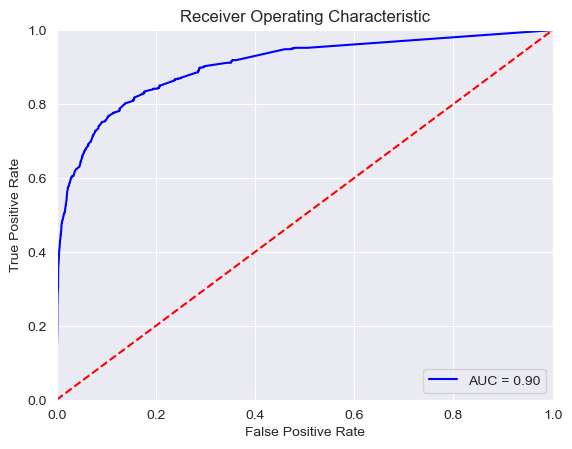

In [122]:
evaluate_model(rf, X_test_clean, y_test_clean, "none")

#### Auswertung

- Modelle, die eine gute Precision erzielen, haben einen schlechten Recall => die getroffenen Vorhersagen sind gut, allerdings werden nicht viele korrekt vorhergesagt (wenige true positives)
- Modelle, die einen guten Recall erzielen, haben einen schlechten Recall => es werden mehr korrekt vorhergesagt, allerdings bei allgemein schlechteren Vorhersagen (mehr false positives)
- deutlich erkennbar am f1 score => Modelle mit bester Precision/Recall mit schlechtem f1 score
- o.g. Punkte sowohl in Train als auch Test zu sehen
- bestes Modell: RandomForest ohne Tuning => ca. 81% Precision und 43% Recall bei Test, bei Train ~99%; cross validation (10) führt zu f1 von ~52%
- Performance RF deutet auf Overfitting hin, mittels RandomizedSearchCV jedoch kein Modell mit geringerer Train aber besserer Test Performance erreichbar (gilt auch für BalancedRandomForestClassifier)
